In [1]:
import pandas as pd
import seaborn as sns
import pickle as pkl

In [1]:
query_dict = {
    2022: 'iPhone 14',
    2021: 'iPhone 13',
    2020: 'iPhone 12',
    2019: 'iPhone 11',
    2018: 'iPhone (XR, XS)',
    2017: 'iPhone (8, X)',
    2016: 'iPhone 7',
    2015: 'iPhone 6S'
}

In [4]:
with open('data/iphon_data_6s_14.pkl', 'wb') as f:
    data_dict = pkl.load(f)

In [6]:
for year, df in data_dict.items():
    df['model_year'] = year
    df['model'] = query_dict[year]
ip_data = pd.concat([df for df in data_dict.values()])
ip_data = ip_data.reset_index(drop=True)

In [7]:
condition_dict = {
    'Brand New': 'condition_new',
    'Open Box': 'condition_like_new',
    'Certified - Refurbished': 'condition_refurbished_0',
    'Excellent - Refurbished': 'condition_refurbished_1',
    'Very Good - Refurbished': 'condition_refurbished_2',
    'Good - Refurbished': 'condition_refurbished_3',
    'Refurbished': 'condition_refurbished_4',
    'Pre-Owned': 'condition_used'
}
ip_data['condition'] = None
for condition_tag, col_name in condition_dict.items():
    ip_data[col_name] = 0
    condition_subset = ip_data['tags'].apply(lambda tags: condition_tag in tags)
    ip_data.loc[condition_subset, 'condition'] = col_name
    ip_data.loc[condition_subset, col_name] = 1

In [8]:
# Filtering
ip_data_filt = ip_data.loc[~ip_data['seller_name'].isnull()]

In [16]:
# Fix model years
model_dict = {
    'iPhone 14': 2022,
    'iPhone 13': 2021,
    'iPhone 12': 2020,
    'iPhone 11': 2019,
    'iPhone XS': 2018,
    'iPhone XR': 2018,
    'iPhone X': 2017,
    'iPhone 8': 2017,
    'iPhone 7': 2016,
    'iPhone 6S': 2015
}
def model_fix(row):
    prod_name = str(row['name']).lower()
    prod_model = str(row['model']).lower()
    prod_model_year = row['model_year']
    if prod_model in prod_name:
        return prod_model_year, prod_model
    for model, year in model_dict.items():
        if model.lower() in prod_name:
            return year, model
    return None, None
        
ip_data_filt[['fixed_model_year', 'fixed_model']] = ip_data_filt.apply(model_fix, axis=1, result_type='expand')

C:\Users\peace\AppData\Local\Temp\ipykernel_10332\755937985.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ip_data_filt[['fixed_model_year', 'fixed_model']] = ip_data_filt.apply(model_fix, axis=1, result_type='expand')
C:\Users\peace\AppData\Local\Temp\ipykernel_10332\755937985.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ip_data_filt[['fixed_model_year', 'fixed_model']] = ip_data_filt.apply(model_fix, axis=1, result_type='expand')


In [18]:
# Model Fix cont.
ip_data_filt = ip_data_filt.loc[~ip_data_filt['fixed_model'].isnull()]
ip_data_filt['model_year'] = ip_data_filt['fixed_model_year']
ip_data_filt['model'] = ip_data_filt['fixed_model']

<AxesSubplot:xlabel='price', ylabel='Density'>

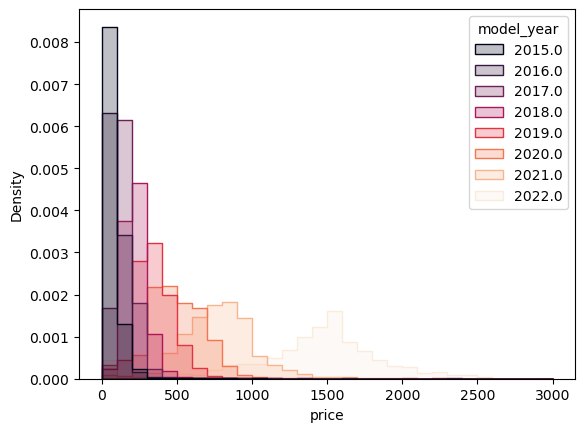

In [19]:
sns.histplot(
    ip_data_filt, 
    x='price', 
    stat='density',
    common_norm=False,
    binrange=[0,3000], 
    binwidth=100,
    element='step',
    hue='model_year', 
    palette=sns.color_palette("rocket", as_cmap=True))

In [20]:
ip_data_agg = ip_data_filt.groupby(['model_year', 'condition']).agg({'price':['min', 'max', 'mean', 'count']})
ip_data_agg.columns = ['_'.join(col) for col in ip_data_agg.columns.values]
ip_data_agg = ip_data_agg.reset_index()

In [25]:
def cost_per_year(row):
    year = row['model_year']
    price = row['price_mean']
    remaining_years = year - 2015 + 1
    mean_price_per_year = price/remaining_years
    return mean_price_per_year

ip_data_agg['mean_price_per_year'] = ip_data_agg.apply(cost_per_year, axis=1)

<AxesSubplot:xlabel='model_year', ylabel='price_mean'>

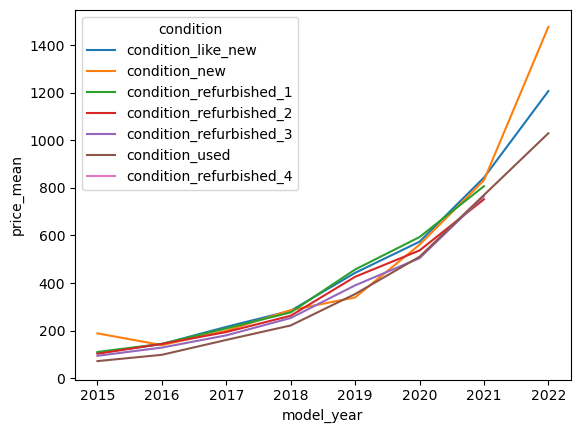

In [21]:
sns.lineplot(data=ip_data_agg, x='model_year', y='price_mean', hue='condition')

<AxesSubplot:xlabel='model_year', ylabel='mean_price_per_year'>

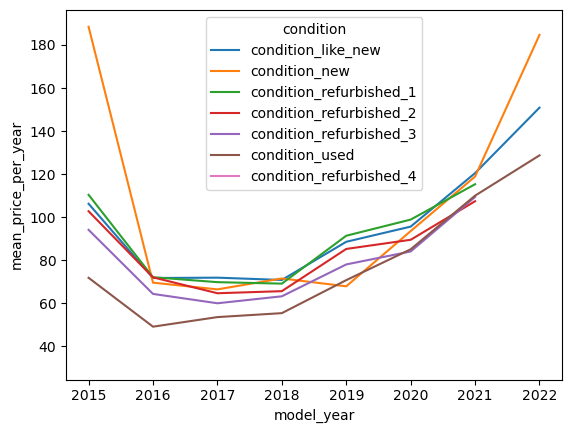

In [26]:
sns.lineplot(data=ip_data_agg, x='model_year', y='mean_price_per_year', hue='condition')